In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
batch_size = 100

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
])

In [ ]:
mnist = torchvision.datasets.MNIST(root='datasets/',
                                   train = True, 
                                   transform = transform,
                                   download = True)

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist, 
                                          batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
#images, labels = iter(data_loader).next()

images, labels = iter(data_loader).next()

In [ ]:
images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [ ]:
labels

tensor([2, 3, 1, 0, 6, 3, 7, 7, 8, 8, 6, 7, 9, 9, 3, 3, 0, 8, 0, 5, 9, 6, 7, 6,
        6, 4, 5, 6, 0, 4, 8, 5, 7, 7, 9, 6, 9, 9, 7, 1, 2, 6, 9, 7, 1, 8, 2, 6,
        1, 3, 4, 0, 7, 1, 7, 7, 3, 4, 8, 5, 7, 1, 1, 4, 0, 7, 0, 3, 7, 0, 5, 5,
        3, 5, 7, 9, 5, 0, 0, 1, 5, 2, 5, 1, 5, 3, 1, 0, 8, 2, 3, 0, 8, 0, 7, 1,
        8, 2, 2, 2])

In [ ]:
img = torchvision.utils.make_grid(images)

In [ ]:
img = img.detach().numpy()
img = img.clip(0, 1)

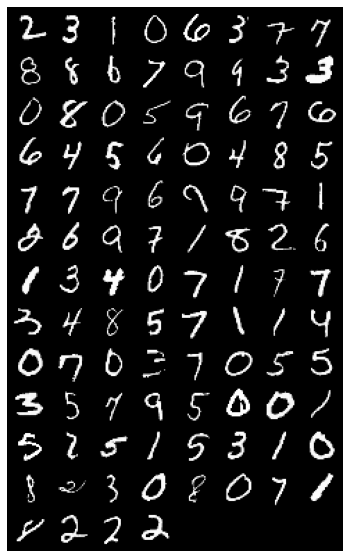

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100

In [ ]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [ ]:
D = D.to(device)
G = G.to(device)

In [ ]:
bce_loss = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
total_step = len(data_loader)

In [ ]:
for epoch in range(num_epochs):
  
  for i, (images, _) in enumerate(data_loader):

    images = images.reshape(batch_size, -1).to(device)

    real_label = torch.ones(batch_size, 1).to(device)
    fake_label = torch.zeros(batch_size, 1).to(device)


    outputs = D(images)

    d_loss_real = bce_loss(outputs, real_label)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)

    outputs = D(fake_images)

    d_loss_fake = bce_loss(outputs, fake_label)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    d_loss.backward()
    d_optimizer.step()

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)

    g_loss = bce_loss(outputs, real_label)

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    g_loss.backward()
    g_optimizer.step()

    if (i+1) % 200 == 0:
      print("Epoch [{} / {}], Step [{} / {}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
      real_score.mean().item(), fake_score.mean().item()))
  
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

Epoch [0 / 100], Step [200 / 600], d_loss: 1.0717, g_loss: 2.1527, D(x): 0.67, D(G(z)): 0.36
Epoch [0 / 100], Step [400 / 600], d_loss: 0.4976, g_loss: 3.2689, D(x): 0.79, D(G(z)): 0.16
Epoch [0 / 100], Step [600 / 600], d_loss: 0.8160, g_loss: 1.7706, D(x): 0.75, D(G(z)): 0.30
Epoch [1 / 100], Step [200 / 600], d_loss: 1.3258, g_loss: 1.2153, D(x): 0.61, D(G(z)): 0.43
Epoch [1 / 100], Step [400 / 600], d_loss: 1.4718, g_loss: 0.7435, D(x): 0.61, D(G(z)): 0.54
Epoch [1 / 100], Step [600 / 600], d_loss: 0.6020, g_loss: 2.1894, D(x): 0.76, D(G(z)): 0.19
Epoch [2 / 100], Step [200 / 600], d_loss: 0.7257, g_loss: 2.2363, D(x): 0.72, D(G(z)): 0.18
Epoch [2 / 100], Step [400 / 600], d_loss: 0.2825, g_loss: 3.3719, D(x): 0.91, D(G(z)): 0.11
Epoch [2 / 100], Step [600 / 600], d_loss: 0.8436, g_loss: 1.9763, D(x): 0.76, D(G(z)): 0.19
Epoch [3 / 100], Step [200 / 600], d_loss: 0.5627, g_loss: 2.0933, D(x): 0.86, D(G(z)): 0.21
Epoch [3 / 100], Step [400 / 600], d_loss: 0.6477, g_loss: 2.4087, D(x

In [ ]:
img = torchvision.utils.make_grid(fake_images)

In [ ]:
img = img.detach().cpu().numpy()
img = img.clip(0, 1)


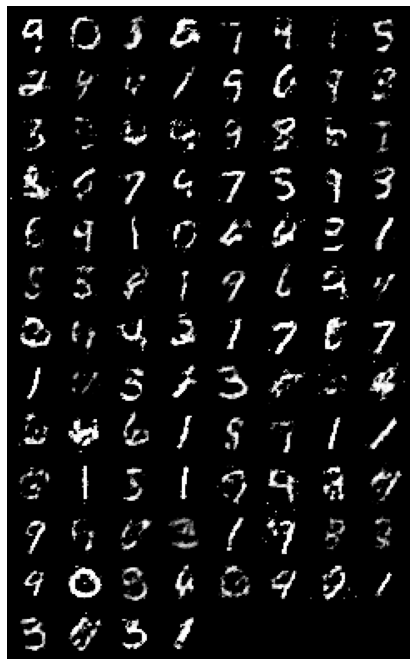

In [ ]:
plt.figure(figsize = (12, 12))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()